In [1]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
import pylab as pl

In [12]:
def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

class SVM(object):

    def __init__(self, kernel=gaussian_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)
            
    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        a = np.ravel(solution['x'])

        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print ("%d support vectors out of %d points" % (len(self.a), n_samples))

        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)


    def project(self, X):
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            s = 0
            for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                s += a * sv_y * self.kernel(X[i], sv)
            y_predict[i] = s
        return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))


     pcost       dcost       gap    pres   dres
 0:  1.7662e+03 -4.2894e+04  8e+04  4e-01  4e-14
 1:  1.7957e+03 -5.2247e+03  7e+03  4e-03  5e-14
 2:  4.9432e+01 -9.1588e+02  1e+03  1e-05  4e-14
 3: -1.0116e+01 -8.9563e+02  9e+02  1e-05  4e-14
 4: -1.5706e+02 -7.6632e+02  6e+02  6e-06  3e-14
 5: -2.7316e+02 -5.6522e+02  3e+02  2e-06  3e-14
 6: -3.0022e+02 -5.4168e+02  2e+02  1e-06  3e-14
 7: -3.3560e+02 -4.8073e+02  1e+02  6e-07  3e-14
 8: -3.5827e+02 -4.3477e+02  8e+01  1e-07  4e-14
 9: -3.7891e+02 -4.0618e+02  3e+01  1e-13  4e-14
10: -3.8618e+02 -3.9545e+02  9e+00  2e-13  4e-14
11: -3.8924e+02 -3.9115e+02  2e+00  2e-13  4e-14
12: -3.9011e+02 -3.9018e+02  7e-02  1e-14  5e-14
13: -3.9014e+02 -3.9014e+02  7e-04  9e-14  4e-14
14: -3.9014e+02 -3.9014e+02  7e-06  6e-14  4e-14
Optimal solution found.
22 support vectors out of 180 points
19 out of 20 predictions correct


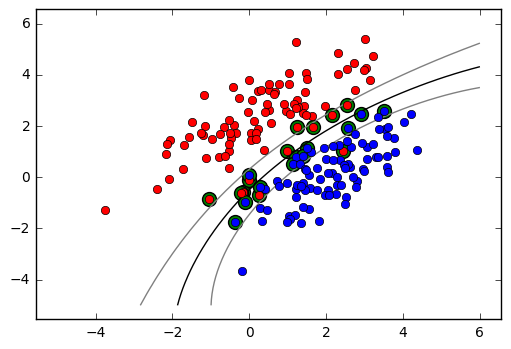

In [17]:
def gen_lin_separable_overlap_data():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[1.5, 1.0], [1.0, 1.5]])
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

def split_train(X1, y1, X2, y2):
    X1_train = X1[:90]
    y1_train = y1[:90]
    X2_train = X2[:90]
    y2_train = y2[:90]
    X_train = np.vstack((X1_train, X2_train))
    y_train = np.hstack((y1_train, y2_train))
    return X_train, y_train

def split_test(X1, y1, X2, y2):
    X1_test = X1[90:]
    y1_test = y1[90:]
    X2_test = X2[90:]
    y2_test = y2[90:]
    X_test = np.vstack((X1_test, X2_test))
    y_test = np.hstack((y1_test, y2_test))
    return X_test, y_test

def plot_contour(X1_train, X2_train, clf):
    pl.plot(X1_train[:,0], X1_train[:,1], "ro")
    pl.plot(X2_train[:,0], X2_train[:,1], "bo")
    pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

    X1, X2 = np.meshgrid(np.linspace(-5,6,50), np.linspace(-5,6,50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = clf.project(X).reshape(X1.shape)
    pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

    pl.axis("tight")
    pl.show()

def test_soft():
    X1, y1, X2, y2 = gen_lin_separable_overlap_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = SVM(C=23)
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print ("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

test_soft()